In [155]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR

In [31]:
def showimg(img):
    cv2.imshow('img',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [271]:
##영상 데이터
video_file = "./dataset1/first_env10_bpm20cm.mp4"
cap = cv2.VideoCapture(video_file)
ret, img = cap.read()
height, width, channel = img.shape
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
showimg(gray)

In [41]:
frame = img
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) # BGR을 HSV로 변환해줌 # define range of blue color in HSV 
lower_green = np.array([25, 150, 25]) # 초록색 범위 
upper_green = np.array([90, 255, 255])
mask2 = cv2.inRange(hsv, lower_green, upper_green) # Bitwise-AND mask and original image 
res2 = cv2.bitwise_and(frame, frame, mask=mask2) # 흰색 영역에 빨강색 마스크를 씌워줌. 
res2 = 255 - res2
inversion_gray = cv2.cvtColor(res2, cv2.COLOR_BGR2GRAY)
showimg(inversion_gray)


In [198]:
## 이미지 그레이로 변경
img_ori = cv2.imread('./dataset1/111.jpg')
height, width, channel = img_ori.shape
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

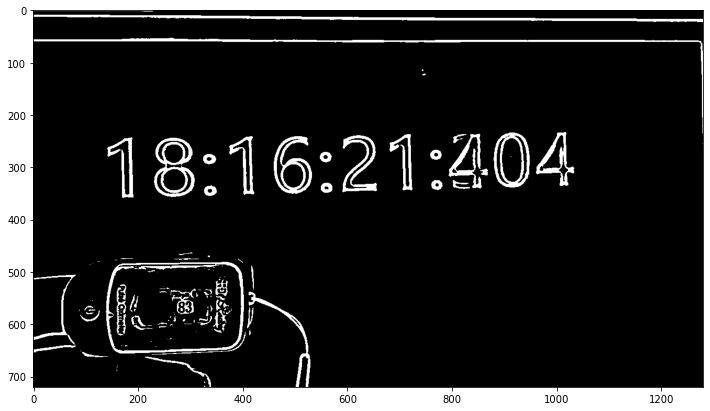

In [272]:
##가우시안 블러 처리후 2진화
img_blurred = cv2.GaussianBlur(gray, ksize=(3, 3), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

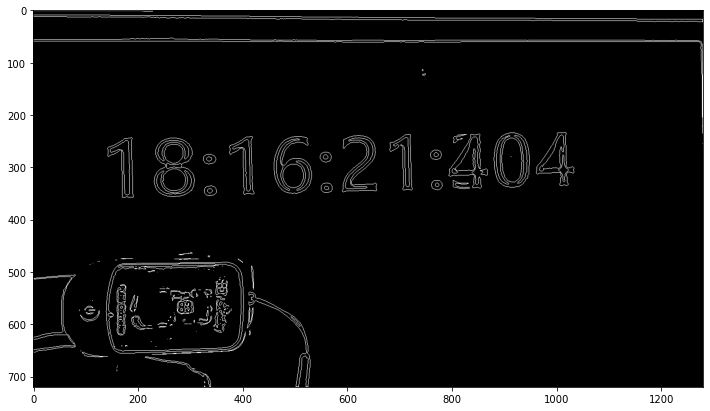

In [273]:
## 윤곽선 찾기
contours, _ = cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

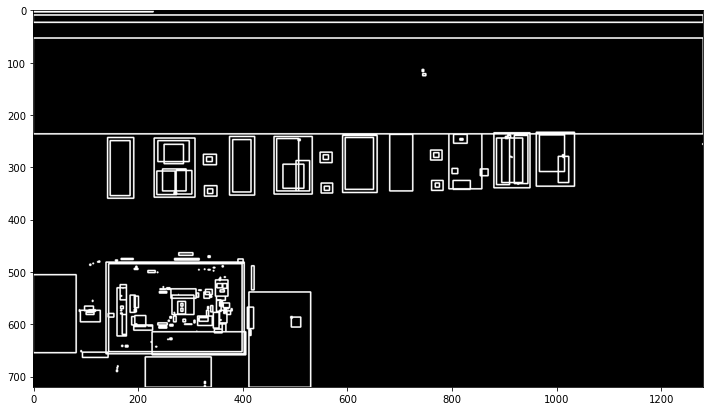

In [274]:
## 모든 윤곽선 사각형으로 변환(준비단계)
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

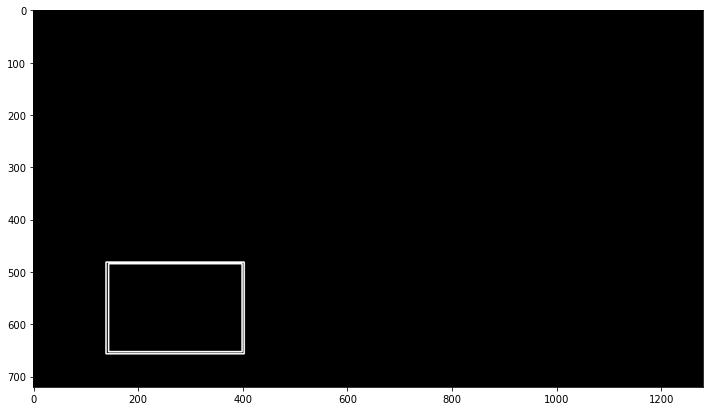

In [275]:
## BPM 데이터 후보군 찾기
MIN_AREA = 1000    #최소 넓이
MIN_WIDTH, MIN_HEIGHT = 100, 80    #최소 길이, 최소 높이
MIN_RATIO, MAX_RATIO = 1.4, 1.7    #가로 대비 세로 비율의 최소, 최대

bpm_possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        bpm_possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in bpm_possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

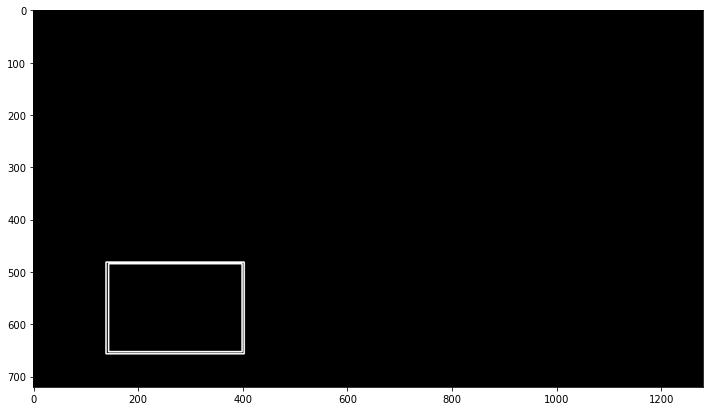

In [276]:
## bpm 측정기 후보군 찾기
one_third_X = round(height/3*2)
one_third_Y = round(width/3*1)

bpm_contour_result = []

for contour in bpm_possible_contours:
    if contour["x"] < one_third_X and contour["y"] > one_third_Y:
        bpm_contour_result.append(contour)

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in bpm_contour_result:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

In [279]:
PLATE_WIDTH_PADDING = 3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 2
MAX_PLATE_RATIO = 15

ocr = PaddleOCR(use_angle_cls=True, lang='en')
plate_imgs = []
for result in bpm_contour_result:
    img_cropped = cv2.getRectSubPix(
        img_thresh, 
        patchSize=(int(result["w"]), int(result["h"])), 
        center=(int(result["cx"]), int(result["cy"]))
        )
    plate_imgs.append(img_cropped)
reslut_text = ""
for img in plate_imgs:
    result = ocr.ocr(img, cls=True)
    showimg(img)
    print(result)
    try:
        result = result[0][-1][0]   #이미지 인식이 불가능 하면 공백을 반환함 따라서 범위 오류가 남
    except IndexError : 
        result = "" 
    if len(result) >=2  and result.isdigit():
        reslut_text = result
        print(result)
        break
print("마지막: ",reslut_text)
# plate_infos.append({
#     'x': int(plate_cx - plate_width / 2),
#     'y': int(plate_cy - plate_height / 2),
#     'w': int(plate_width),
#     'h': int(plate_height)
# })



Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\kgg/.paddleocr/2.4\\ocr\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\kgg/.paddleocr/2.4\\ocr\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5, e2e_pg

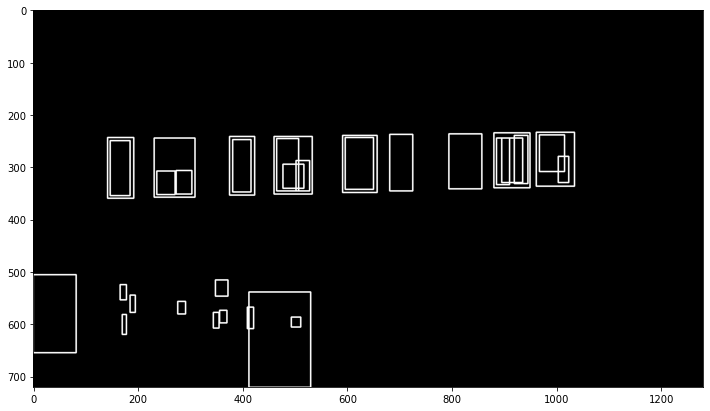

In [278]:
## 시계 데이터 후보군 찾기
MIN_AREA = 200    #최소 넓이
MIN_WIDTH, MIN_HEIGHT = 2, 9    #최소 길이, 최소 높이
MIN_RATIO, MAX_RATIO = 0.2, 1.0    #가로 대비 세로 비율의 최소, 최대

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

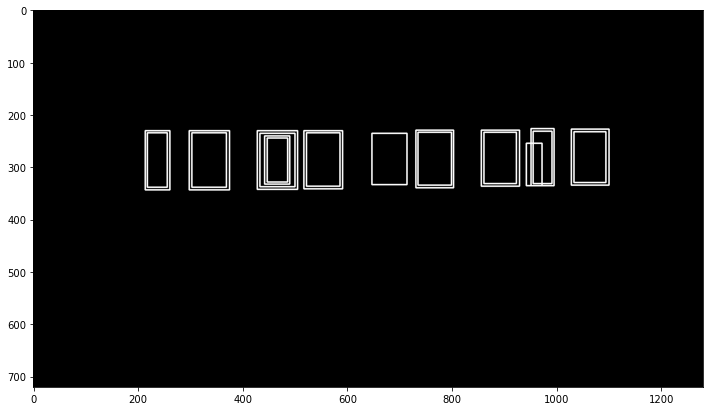

In [255]:
## 배열을 통해서 가능성이 높은 컨투어 파악
MAX_DIAG_MULTIPLYER = 6.5 # 5    #컨투어의 대각선길이와 두 컨투어 사이의 중심 좌표의 배수
MAX_ANGLE_DIFF = 5.0 # 12.0    #두 컨투의 사이의 세타θ 값
MAX_AREA_DIFF = 0.7 # 0.5    #컨투어의 면적 차이
MAX_WIDTH_DIFF = 1.0    #컨투어의 가로길이 차이
MAX_HEIGHT_DIFF = 0.4     #컨투어의 세로 길이 차이
MIN_N_MATCHED = 3 # 3    #위의 조건들을 만족하는 컨투어의 개수

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
#         cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)
plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

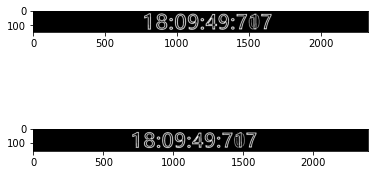

In [256]:
## 기울기 맞추기
PLATE_WIDTH_PADDING = 3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 2
MAX_PLATE_RATIO = 15

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')

In [257]:
def img_to_string(img_list):
    ocr = PaddleOCR(use_angle_cls=True, lang='en') # need to run only once to download and load model into memory
    result_string = ""
    for img in img_list:
        result = ocr.ocr(img, cls=True)
        print(result)
        result_string = result
        try:
            result = result[0][-1][0]   #이미지 인식이 불가능 하면 공백을 반환함 따라서 범위 오류가 남
        except IndexError : 
            result = "" 
        if len(result) == 12:
            result_string = result
            break
    return result_string
result = img_to_string(plate_imgs)
result

Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\kgg/.paddleocr/2.4\\ocr\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\kgg/.paddleocr/2.4\\ocr\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5, e2e_pg

'18:09:49:717'

Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\kgg/.paddleocr/2.4\\ocr\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\kgg/.paddleocr/2.4\\ocr\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5, e2e_pg

IndexError: tuple index out of range

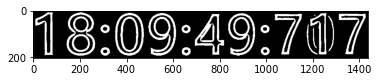

In [258]:
longest_idx, longest_text = -1, 0
plate_chars = []

total_result = []
for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    plt.imshow(img_result, cmap='gray')

    ocr = PaddleOCR(use_angle_cls=True, lang='en') # need to run only once to download and load model into memory
    result = ocr.ocr(img_result, cls=True)
    print(result[0][-1][3])
    total_result.append(result)


In [128]:
## 정확한 시간 데이터 찾기
result_data = ""
if len(total_result) == 1:
    result_data = total_result[0]
elif len(total_result) == 0:
    pass    ##total_reslut가 없을 경우, 빈 문자열
else:
    result_data = total_result[0]
    for result in total_result[1:]:
        if len(result) == 12:
            result_data = result[0]
            break
        elif len(result_data) < len(result):
            result_data = result
print(result_data)